# PREVISÃO DE FALÊNCIA DE EMPRESAS EM ATÉ DOIS ANOS


### Dados:
Fonte: Bisnode - Empresa europeia no ramo de Business Information
Período: De 2005 a 2016
Descritivo: dados anonimizados de empresas do ramo de indústria e serviços com receita abaixo de 100 milhões de Euros. Possui dados contábeis, de boarding, geográficos, datas e dados corporativos gerais.

### Premissas do grupo:
Escopo Geral do Projeto
1. Definir o melhor tratamento de dados, buscando excluir o menor número de empresas sem que haja prejuízo na qualidade das variáveis
2. Tratar missing values, valores negativos, identificação e influência de outliers na modelagem
3. Identificação, criação e seleção de variáveis que podem melhorar a performance dos modelos preditivos
4. Identificar qual modelo possui melhor performance de previsão

### Premissas do projeto:
Passo a passo de tratamentos obrigatórios
1. Remover das colunas
2. Remover de dados do ano de 2016
3. Tratar missing values de Sales
5. Tratar dados negativos em Sales
6. Criar variável resposta
7. Filtrar apenas empresas de 2012
8. Criar coluna log_sales
7. Fitrar revenue
9. Tirar empresas do ano de 2012 com sales == 0

# PASSO 01 - TRATAMENTO DA BASE DE ACORDO COM O ROTEIRO

## 1.1. imports:

In [123]:
# bibliotecas:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import missingno as msno

In [124]:
# dataset:

df = pd.read_csv('cs_bisnode_panel.csv')

## 1.2. Tratamentos iniciais

In [125]:
# removendo colunas 'COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D':
df = df.drop(['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D'], axis=1)

# removendo dados do ano de 2016 da coluna year:
df = df[df['year']!=2016].reset_index()

## 1.3. Tratar os missing values de sales 
- Critério: Retirar empresas que possuam ao menos 1 missing value nos anos de 2012, 2013 ou 2014
- Escolhemos estes anos uma vez que:
- 2012 - Será o ano de todos os dados após a criação da variável resposta
- 2013 e 2014 - Serão utilizados para criação da variável resposta

In [126]:
filter_years = [2012, 2013, 2014]

comp_missing = df[(df['year'].isin(filter_years) & df['sales'].isna())]["comp_id"].unique()

mask = ~df["comp_id"].isin(comp_missing)

df = df[mask]


## 1.4. Valores Negativos em Sales
1. Há poucos valores negativos. 
2. Valores negativos podem representar um erro. 
* Logo, substituir esses missing values por zero não tratará prejuízo ao modelo

In [127]:
#verificar o numero de comp_id com valores de sales negativas
df[df['sales']<0]['comp_id'].unique().size

#Tranformar as Sales negativas em 0
df['sales'] = df['sales'].apply(lambda x: 0 if x < 0 else x).reset_index(drop = True)

## 1.5. Criar variável resposta

Variável "will_close" que indique se a empresa não possui vendas no ano seguinte *E* no próximo, desde que ela apresente venda no ano atual.

In [128]:
# Ordenar por 'comp_id' e 'year' para utilização da função shift:
df = df.sort_values(['comp_id', 'year'])

# Condicionais para verificação de empresas que fecharam:
df['will_close'] = np.where(
    (df['sales'] > 0) 
    & 
    (df.groupby('comp_id')['sales'].shift(-1) <= 0) 
    & 
    (df.groupby('comp_id')['sales'].shift(-2) <= 0), 1, 0)

# Verificando se a variável foi criada corretamente:
df[['comp_id', 'year','sales', 'will_close']].head(11).sort_values('comp_id')



,comp_id,year,sales,will_close
0,1001034.0,2005,62751.851562,0
1,1001034.0,2006,64625.925781,0
2,1001034.0,2007,65100.000000,0
3,1001034.0,2008,78085.187500,0
4,1001034.0,2009,45388.890625,0
5,1001034.0,2010,9929.629883,1
6,1001034.0,2011,0.000000,0
7,1001034.0,2012,0.000000,0
8,1001034.0,2013,0.000000,0
9,1001034.0,2014,0.000000,0


## 1.6. Filtrar empresas do ano de 2012

In [129]:
df = df[df['year']==2012]

## 1.7. criar coluna em log da variável sales:


In [130]:
df['log_sales'] = np.log(df['sales'])

c:\Users\TEP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 1.8. Filtro de revenue para empresas com receita maior que 1000 e menor que 10 MM

In [131]:
# Pega a média de vendas de uma empresa durante os anos determinados
revenue = df.groupby('comp_id')['sales'].mean()

# Junta a coluna criada no dataframe original
df = df.merge(revenue, how="inner", on="comp_id").rename(columns={"sales_y": "revenue"})

#Filtro para selecionar empresas com revenue maior que 1000 e menor que 10 MM
df = df[(df["revenue"] > 1000) & (df["revenue"] < 10000000)]

## 1.9. Retirando empresas que apresentaram sales == 0 da base
* Empresas sem vendas no ano de 2012 não são úteis para verificarmos se a empresa irá fechar em 2 anos ou não


In [132]:
df = df[df['sales_x'] != 0]

# PASSO 02 - DESCRIÇÃO DOS DADOS

## 2.1. Dimensão dos dados

In [133]:
print( 'Numero de Linhas: {}'.format( df.shape[0] ) )
print( 'Número de Colunas: {}'.format( df.shape[1] ) )

Numero de Linhas: 21045
Número de Colunas: 46


## 2.2. Tipo dos dados


In [134]:
df.dtypes

index                     int64
comp_id                 float64
begin                    object
end                      object
amort                   float64
curr_assets             float64
curr_liab               float64
extra_exp               float64
extra_inc               float64
extra_profit_loss       float64
fixed_assets            float64
inc_bef_tax             float64
intang_assets           float64
inventories             float64
liq_assets              float64
material_exp            float64
personnel_exp           float64
profit_loss_year        float64
sales_x                 float64
share_eq                float64
subscribed_cap          float64
tang_assets             float64
balsheet_flag             int64
balsheet_length           int64
balsheet_notfullyear      int64
year                      int64
founded_year            float64
exit_year               float64
ceo_count               float64
foreign                 float64
female                  float64
birth_ye

## 2.3. Mudando Tipo dos Dados

Vamos converter os tipos de dados algumas colunas para que estas esteja coerentes com as descrição das variáveis, a saber:

- comp_id: como é a identificação da empresa, deve ser considerada uma string (object)
- begin: converter para data
- end: converter para data
- founded_date: converter para data
- exit_date: converter para data
- nace_main: converter para string (object)
- ind2: converter para string (object)
- ind: converter para string (object)
- will_close: converter para int64
- urban_m: converter para string pois é uma variável categórica

In [135]:
df['comp_id'] = df['comp_id'].astype('object')
df['begin'] = pd.to_datetime(df['begin'],format="%Y-%m-%d", errors='coerce')
df['end'] = pd.to_datetime(df['end'],format="%Y-%m-%d", errors='coerce')
df['founded_date'] = pd.to_datetime(df['founded_date'],format="%Y-%m-%d", errors='coerce')
df['exit_date'] = pd.to_datetime(df['exit_date'],format="%Y-%m-%d", errors='coerce')
df['nace_main'] = df['nace_main'].astype('object')
df['ind2'] = df['ind2'].astype('object')
df['ind'] = df['ind'].astype('object')
df['will_close'] = df['will_close'].astype('int64')
df['urban_m'] = df['urban_m'].astype('object')


## 2.4. Checando NA

Text(0.5, 1.0, 'Gráfico de Missing Values')

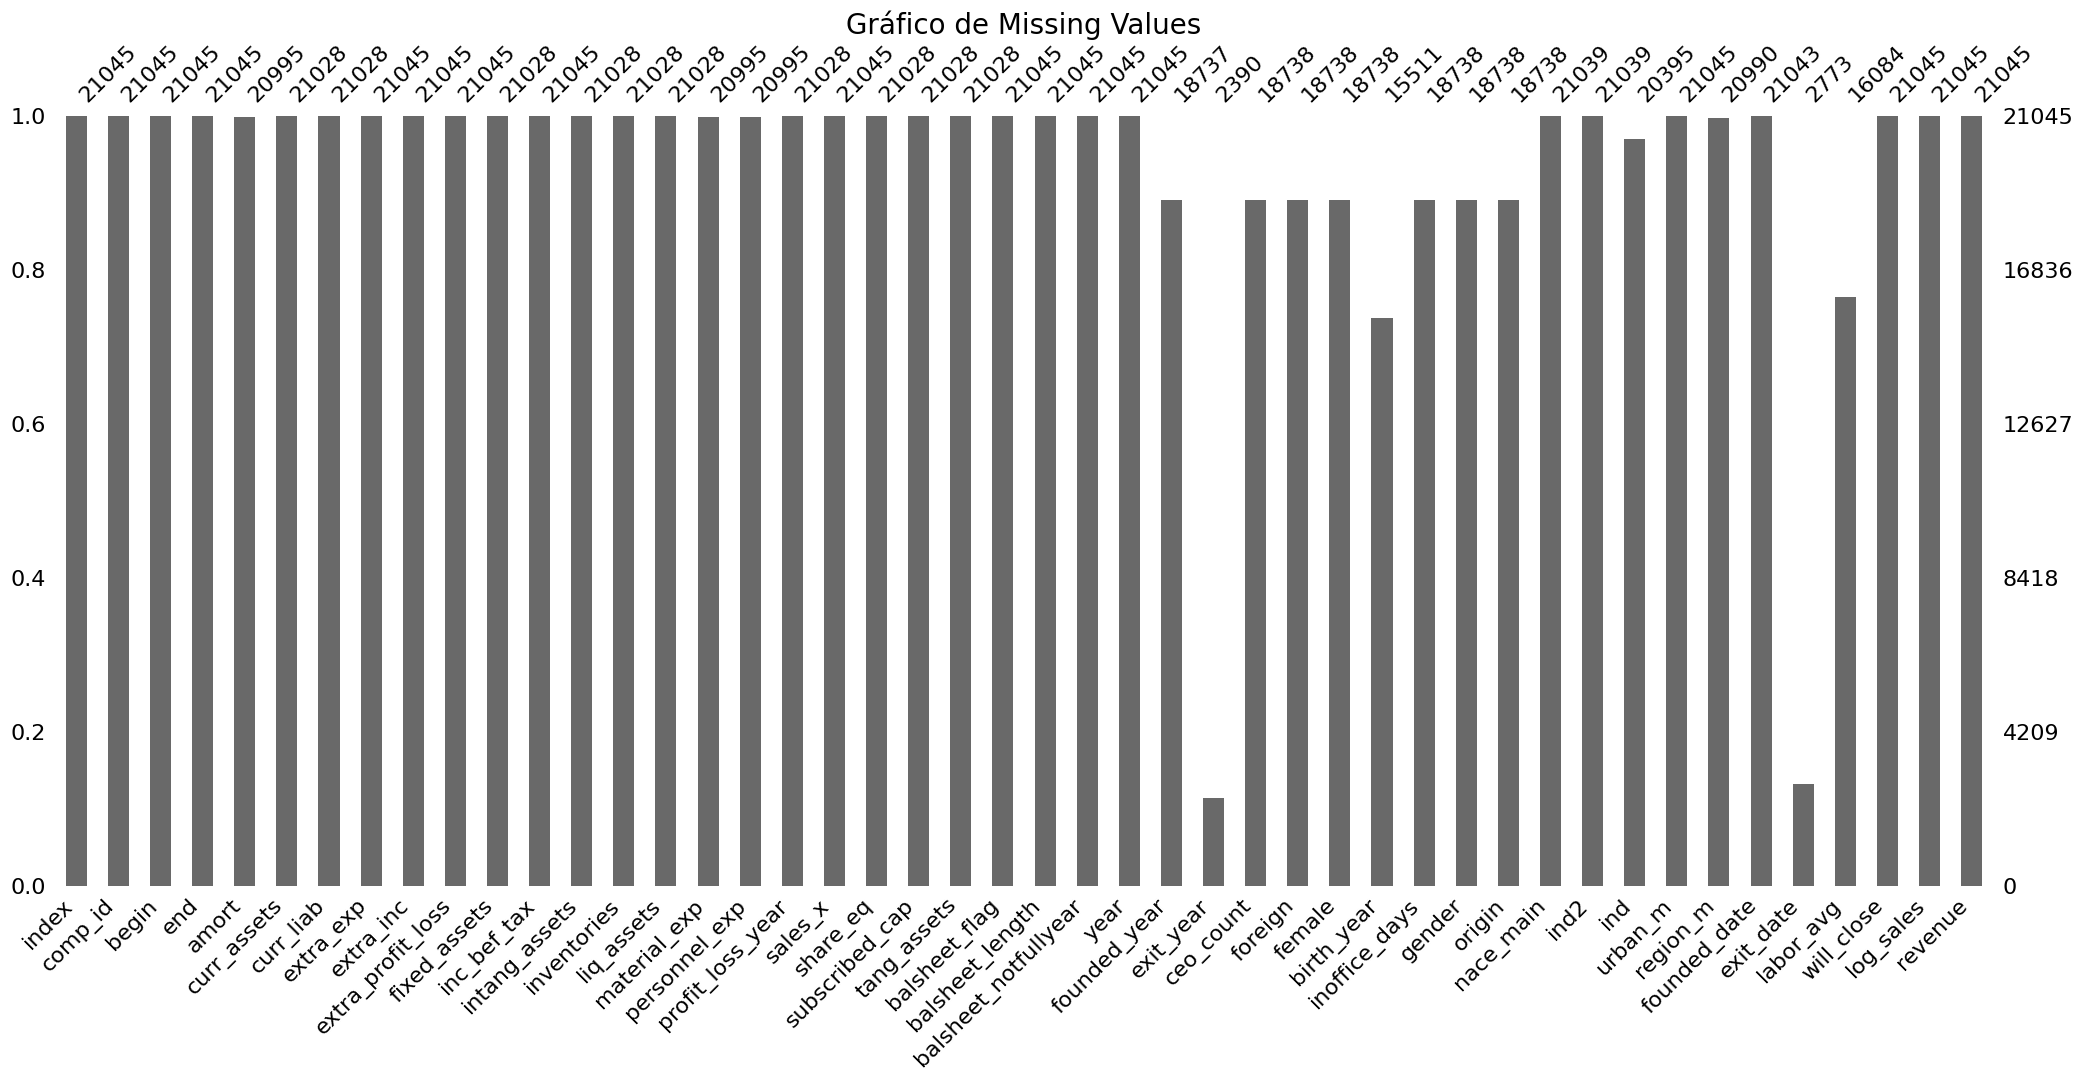

In [136]:
msno.bar(df)
# inserindo título no gráfico:
plt.title('Gráfico de Missing Values', fontsize=20)

## 2.5. Preenchendo NA


As variáveis que continuaram com Missing Values após o tratamento deste atual tópico serão excluídas conforme justificado nos passos seguintes

In [137]:
# Considerar ZERO:

# Como são gastos de natureza eventual, os missing values podem representar que não houve esse tipo de dado para o ano em questão;

df['extra_exp'] = df['extra_exp'].fillna(0)
df['extra_inc'] = df['extra_inc'].fillna(0)
df['extra_profit_loss'] = df['extra_profit_loss'].fillna(0)


# Para Profit_loss_year, share_eq e subscribed_cap, preenchemos com zero pois tinham apenas 17 missing values.

df['profit_loss_year'] = df['profit_loss_year'].fillna(0)
df['share_eq'] = df['share_eq'].fillna(0)
df['subscribed_cap'] = df['subscribed_cap'].fillna(0)



# Subsitutir pela média da empresa as variáveis numéricas: 
# "amort", "curr_assets", "curr_liab", "fixed_assets", "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp", "tang_assets", "labor_avg". 
# São variáveis de natureza contábil e que tem um peso importante para explicar a saúde financeira da empresa. 
# Logo, substituir pela média da empresa mantém a distribuição dos dados intacta e utilizar por ZERO ou excluir os dados pode prejudicar a estimativa do modelo

df['amort'] = df['amort'].fillna(df['amort'].mean())
df['curr_assets'] = df['curr_assets'].fillna(df['curr_assets'].mean())
df['curr_liab'] = df['curr_liab'].fillna(df['curr_liab'].mean())
df['fixed_assets'] = df['fixed_assets'].fillna(df['fixed_assets'].mean())
df['inc_bef_tax'] = df['inc_bef_tax'].fillna(df['inc_bef_tax'].mean())
df['intang_assets'] = df['intang_assets'].fillna(df['intang_assets'].mean())
df['inventories'] = df['inventories'].fillna(df['inventories'].mean())
df['liq_assets'] = df['liq_assets'].fillna(df['liq_assets'].mean())
df['material_exp'] = df['material_exp'].fillna(df['material_exp'].mean())
df['personnel_exp'] = df['personnel_exp'].fillna(df['personnel_exp'].mean())
df['tang_assets'] = df['tang_assets'].fillna(df['tang_assets'].mean())
df['labor_avg'] = df['labor_avg'].fillna(df['labor_avg'].mean())


# Subsitutir pela moda da empresa as variáveis: "urban_m", "region_m", "founded_date", 
# São variáveis não numéricas que podem ajudar na construção do modelo, pois podem ter a priori relevância na explicação da variável resposta.

df['urban_m'] = df['urban_m'].fillna(df['urban_m'].mode())

#substituindo region_m pela moda
mode_series = df['region_m'].mode()
if not mode_series.empty:
    df['region_m'].fillna(mode_series.iloc[0], inplace=True)

#substituindo founded_date pela moda
mode_series2 = df['founded_date'].mode()
if not mode_series2.empty:
    df['founded_date'].fillna(mode_series2.iloc[0], inplace=True)

In [138]:
# verificando valores na:
df.isna().sum()

index                       0
comp_id                     0
begin                       0
end                         0
amort                       0
curr_assets                 0
curr_liab                   0
extra_exp                   0
extra_inc                   0
extra_profit_loss           0
fixed_assets                0
inc_bef_tax                 0
intang_assets               0
inventories                 0
liq_assets                  0
material_exp                0
personnel_exp               0
profit_loss_year            0
sales_x                     0
share_eq                    0
subscribed_cap              0
tang_assets                 0
balsheet_flag               0
balsheet_length             0
balsheet_notfullyear        0
year                        0
founded_year             2308
exit_year               18655
ceo_count                2307
foreign                  2307
female                   2307
birth_year               5534
inoffice_days            2307
gender    

## 2.6. Análise Descritiva

Abaixo serão plotados gráficos boxplot para verificarmos a distribuição dos dados e a existência de outliers para cada variável numérica. 

Como observado alto número de outliers nas variáveis, também serão estimados modelos sem os outliers na etapa de modelagem.

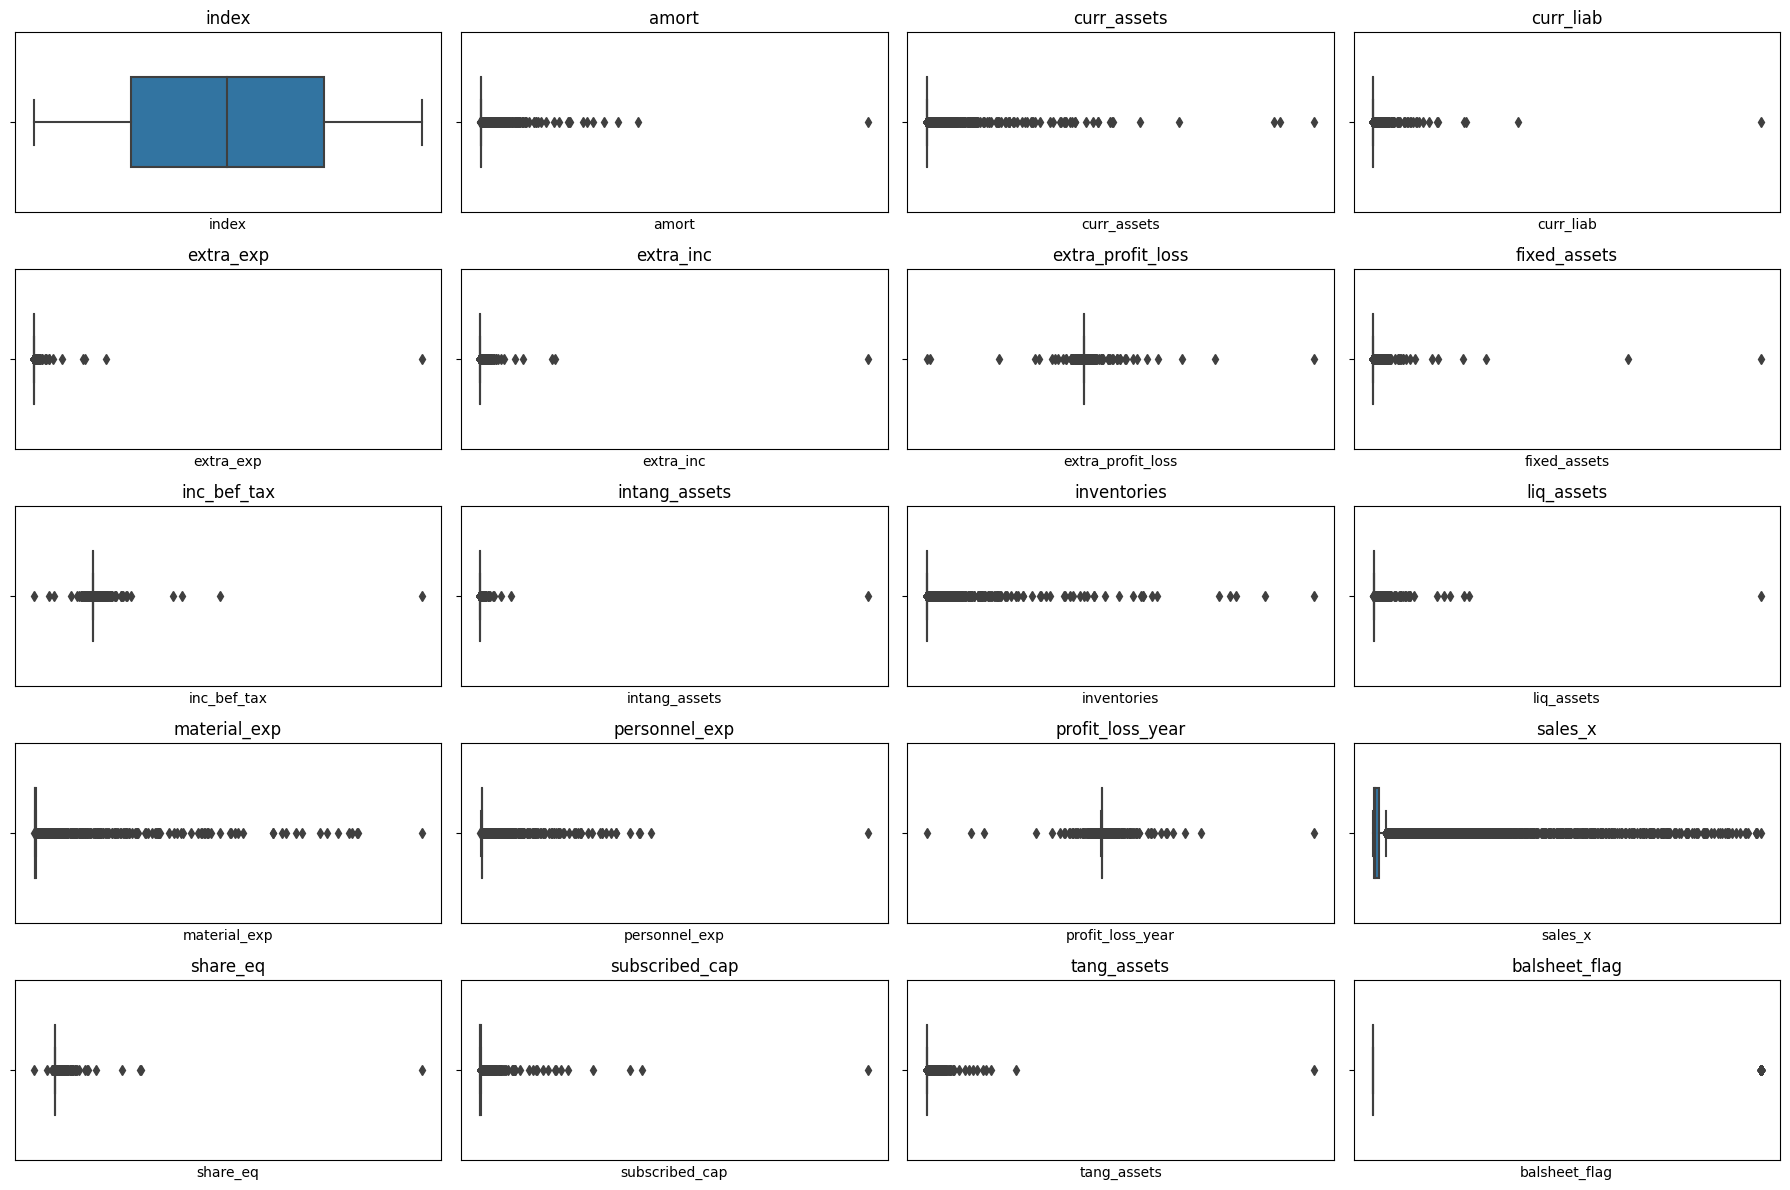

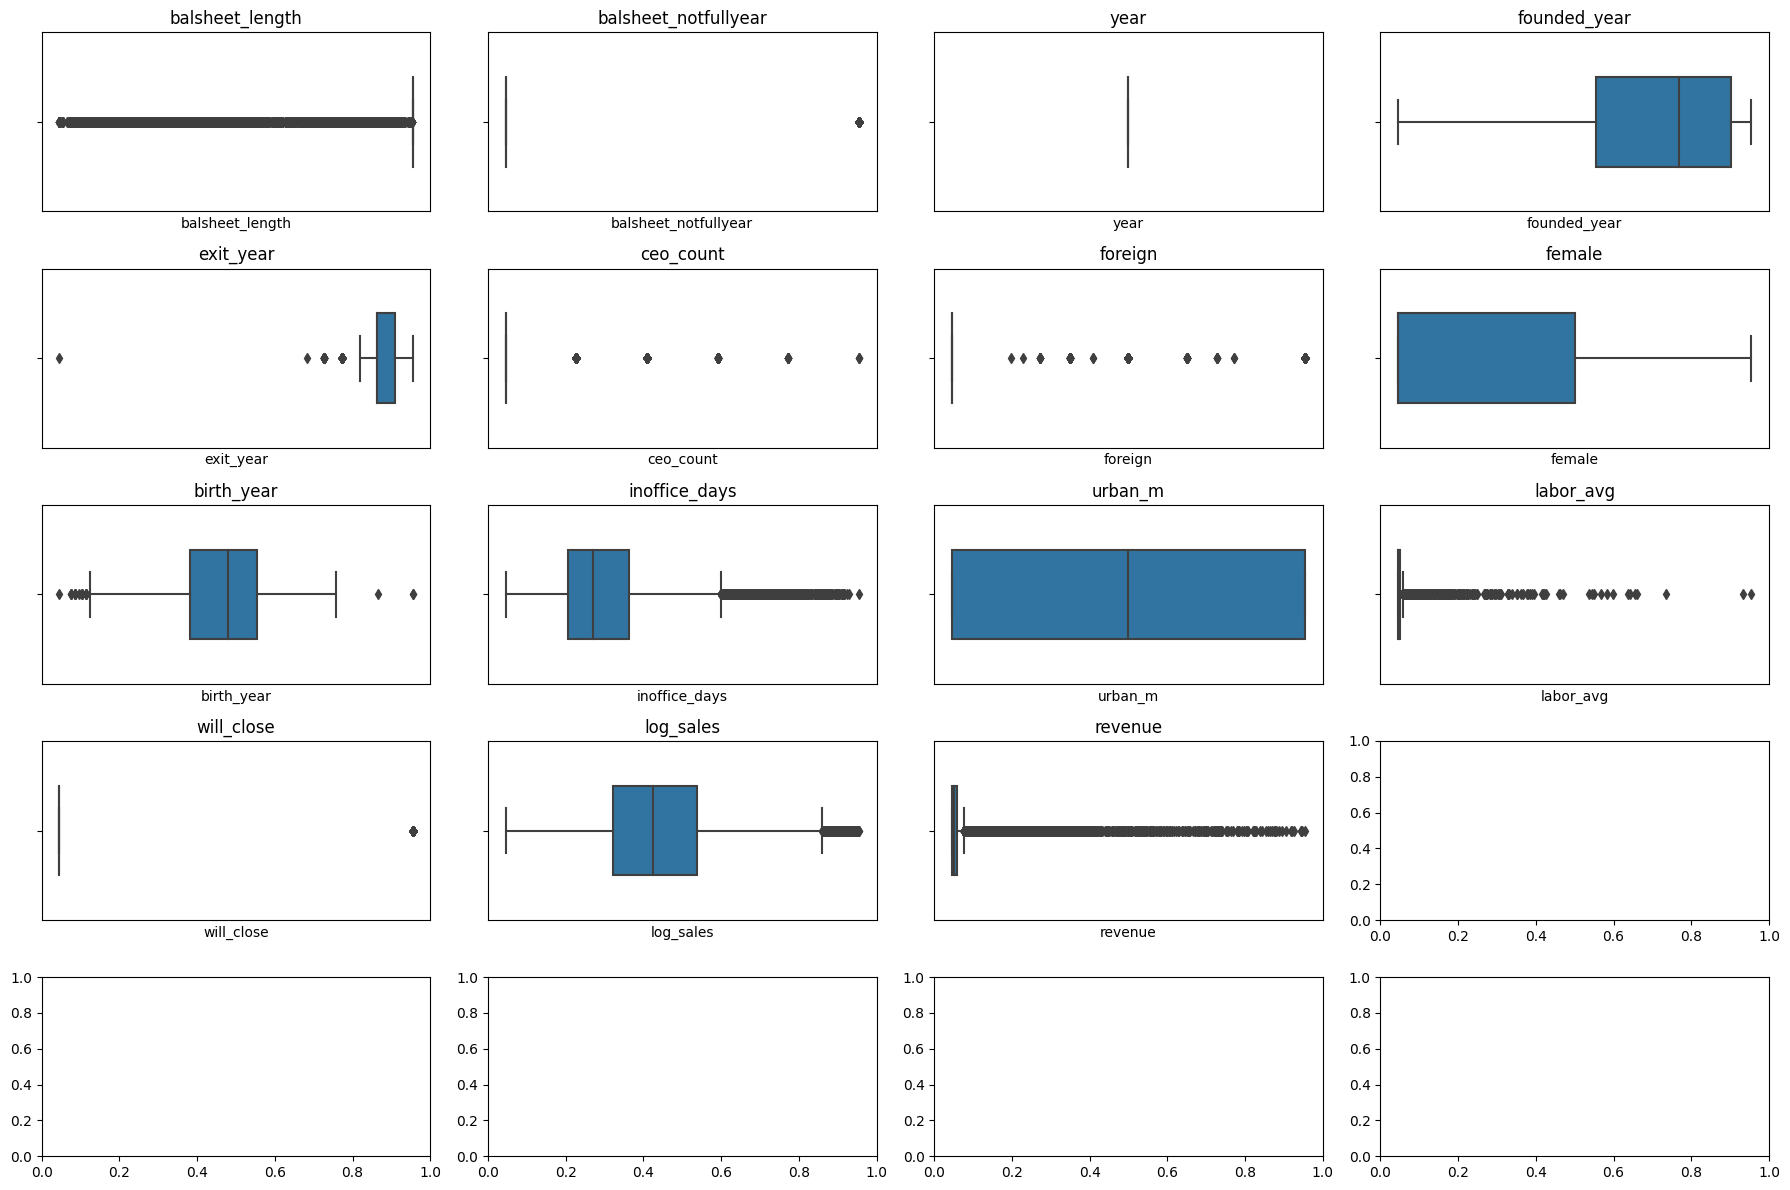

In [139]:

# Fazendo variável com todas as colunas numéricas:
var_num = df.select_dtypes( include=['int64', 'float64'] )

# fazendo boxplot de todas as variáveis numéricas para identificar as distribuições:
colunas = var_num.columns

# Configurações para a disposição dos subplots
num_linhas = 5  
num_colunas = 4  

# Calcula o número total de figuras necessárias
num_total_figuras = (len(colunas) // (num_linhas * num_colunas)) + 1

# Tamanho da figura
tamanho_figura = (18, 12)

# Loop para criar cada figura com os boxplots
for figura_num in range(num_total_figuras):
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=tamanho_figura)
    
    # Colunas para esta figura
    inicio_coluna = figura_num * num_linhas * num_colunas
    fim_coluna = (figura_num + 1) * num_linhas * num_colunas
    colunas_figura = colunas[inicio_coluna:fim_coluna]

    # Iterar pelas colunas e criar os boxplots para esta figura
    for i, coluna in enumerate(colunas_figura):
        linha = i // num_colunas
        col = i % num_colunas
        sns.boxplot(x=var_num[coluna], ax=axs[linha, col], width=0.5)
        axs[linha, col].set_title(coluna)
        axs[linha, col].set_xticks([])  # Remove os rótulos do eixo x

    # Ajustar o layout
    plt.tight_layout()

    # Exibir a figura
    plt.show()

# PASSO 03 - FEATURE ENGINEERING

## 3.1. Criação de colunas

### 3.1.1. Capital Circulante líquido

*curr_assets* -> Ativos Circulantes

*curr_liab* -> Passivos Circulantes

Com esses dois valores, é possível calcular o **capital circulante líquido**, dividindo os ativos circulantes por passivos circulantes. Esse valor significa o quanto a empresa consegue pagar suas contas e dívidas no prazo correto.

É interessante fazer mais uma coluna com esse cálculo pois pode ser um dos motivos aos quais a empresa fechou.

Ex: Caso uma empresa tenha o valor de liquidez corrente igual a 2, significa que a cada 1,00 real de dívida, ela tem 2,00 reais para abater essa dívida.

Então, empresas com valores menores que 1, significa que elas não conseguem abater a dívida naquele ano.

In [140]:
df = df.reset_index(drop=True)
df["curr_idx_liq"] = df["curr_assets"]/df["curr_liab"].replace(0, 1)

### 3.1.2. Idade da empresa

Etapa definida como obrigatória nos pré-requisitos.

Esta coluna foi criada neste momento do notebook sem que haja prejuízo nas etapas anteriores.


In [141]:
# Calcula a idade com base na coluna "year" e "founded_date"
df['comp_age'] = df['year'] - df['founded_date'].dt.year

### 3.1.3. Porte da empresa


Nesse caso o porte da empresa foi definido como:

- Receita menor ou igual a 50 mil: Pequena
- Receita entre 100 mil e 50 mil: Média
- Receita maior ou igual que 100 mil: Grande

In [142]:
#Condições para definir se a empresa é pequena, média ou grande
conditions = [(df["revenue"] <= 50000), 
              (df["revenue"] < 100000) & (df["revenue"] > 50000),
              (df["revenue"] >= 100000)]

choices = ["Pequena", "Média", "Grande"]

df["comp_size"] = np.select(conditions, choices, default=0)

# PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

### 4.1. Variável Resposta

Na base dados temos uma baixa proporção de empresas que fecharão em 2 anos em comparação às que se manterão abertas

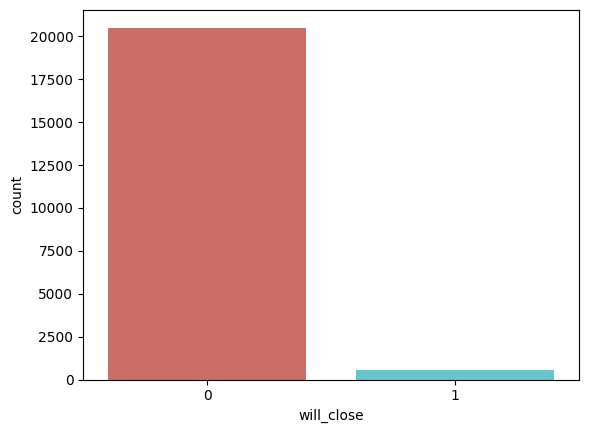

In [143]:
# Fazendo gráfico de barras para a variável "will_close":
sns.countplot(x='will_close', data=df, palette='hls')
plt.show()

## 4.2. Análise Multivariada

Observa-se maior correlação entre as variáveis de cunho financeiro, indicando que possivelmente possuem maior importância explicativa para o modelo.

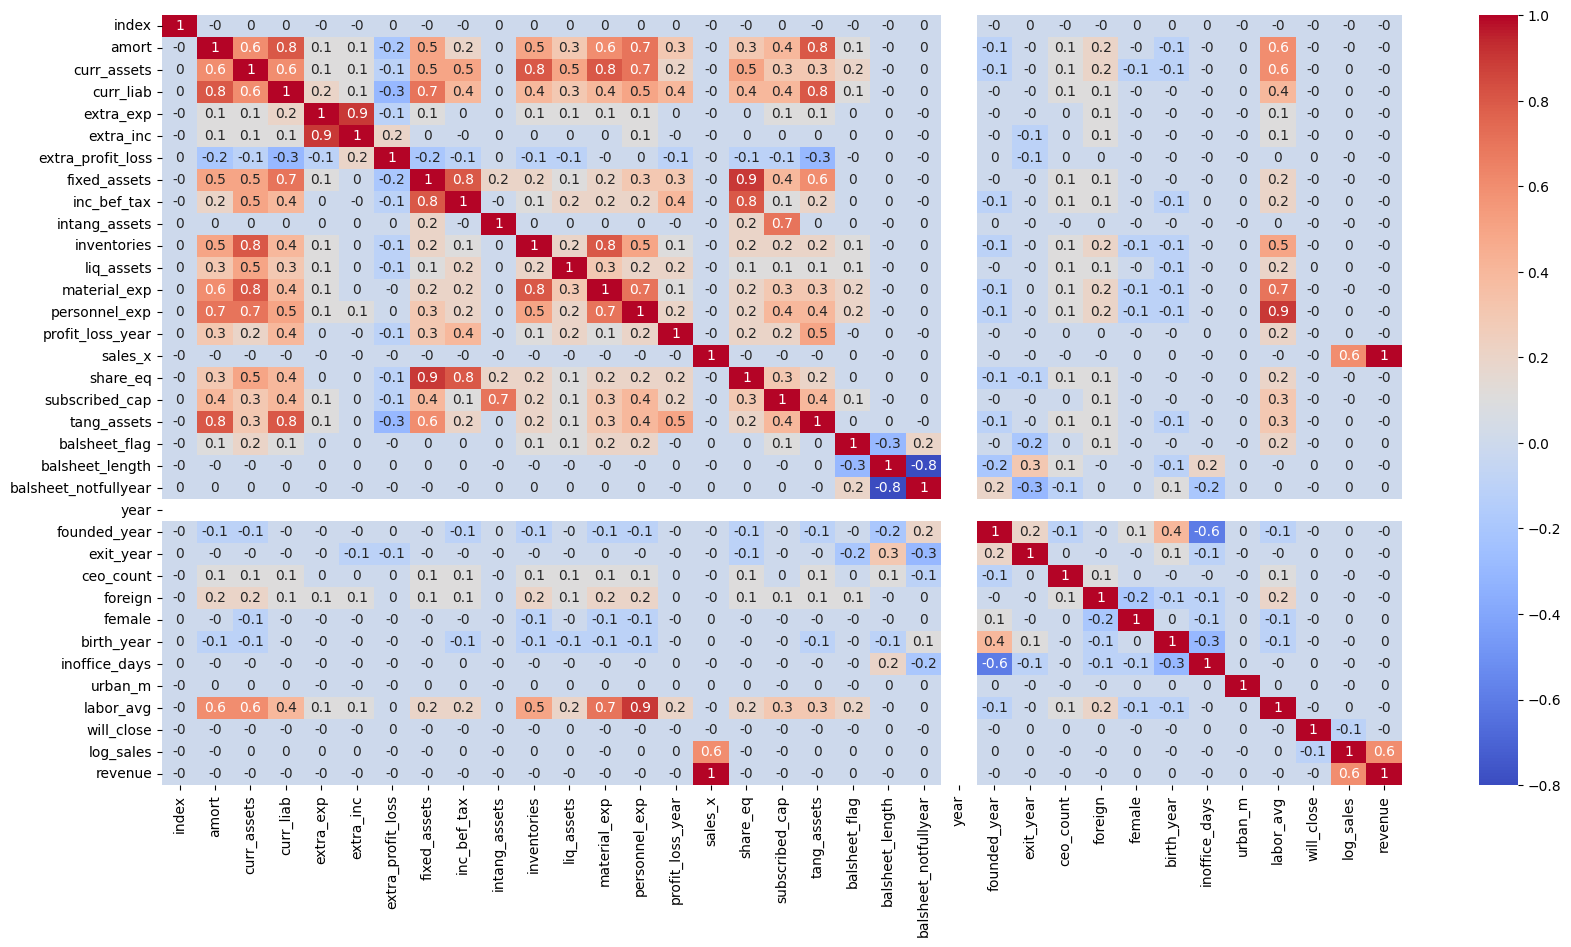

In [144]:
# fazendo heatmap para verificar a correlação entre as variáveis numéricas:
plt.figure(figsize=(20,10))
sns.heatmap(round(var_num.corr(),1), annot=True, cmap='coolwarm')
plt.show()

## 4.3. Analise Bivariada

### 4.3.1. Tamanho da empresa

In [145]:
# Comp_size:

# tabela com porcentagem de empresas fechadas por comp_size:

pd.crosstab(df['comp_size'], df['will_close']).apply(lambda r: r/r.sum(), axis=1)

will_close,0,1
comp_size,,
Grande,0.988420,0.011580
Média,0.987301,0.012699
Pequena,0.961613,0.038387


### 4.3.2. Região

In [146]:
# region_m:

# tabela com porcentagem de empresas fechadas por comp_size:

pd.crosstab(df['region_m'], df['will_close']).apply(lambda r: r/r.sum(), axis=1)

will_close,0,1
region_m,,
Central,0.972529,0.027471
East,0.978490,0.021510
West,0.975394,0.024606


### 4.3.3. Amortização

In [147]:
# verificando 10 recortes da variável amort e a porcentagem de empresas fechadas em cada recorte:
print(df['amort'].min())
print(df['amort'].max())

# criando recortes para a variável amort:

df['amort_recorte'] = pd.cut(df['amort'], bins=[df['amort'].min(), 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, df['amort'].max() ], labels=['<0', '0-1M', '1M-2M', '2M-3M', '3M-4M', '4M-5M', '5M-6M', '6M-7M', 'Max'])

# tabela com porcentagem de empresas fechadas por amort_recorte:
pd.crosstab(df['amort_recorte'], df['will_close']).apply(lambda r: r/r.sum(), axis=1)



-14896.2958984375
15921181.0


will_close,0,1
amort_recorte,,
<0,0.978972,0.021028
0-1M,0.972605,0.027395
1M-2M,0.955556,0.044444
2M-3M,1.000000,0.000000
3M-4M,1.000000,0.000000
4M-5M,1.000000,0.000000
5M-6M,1.000000,0.000000
6M-7M,1.000000,0.000000
Max,1.000000,0.000000


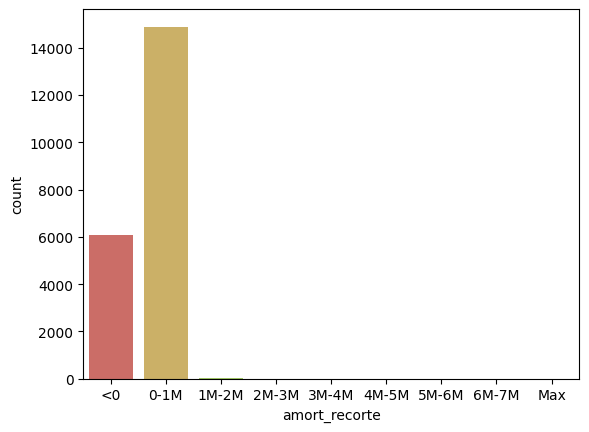

In [148]:
# fazendo gráfico:

sns.countplot(x='amort_recorte', data=df, palette='hls')
plt.show()

#dropando a coluna:
df = df.drop(['amort_recorte'], axis=1)

### 4.3.4. Ativos Circulantes

In [149]:
# verificando 10 recortes da variável curr_assets e a porcentagem de empresas fechadas em cada recorte:
print(df['curr_assets'].min())
print(df['curr_assets'].max())

# criando recortes para a variável:

df['curr_assets_recorte'] = pd.cut(df['curr_assets'], bins=[df['curr_assets'].min(), 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, df['curr_assets'].max() ], labels=['<0', '0-1M', '1M-2M', '2M-3M', '3M-4M', '4M-5M', '5M-6M', '6M-7M', 'Max'])

# tabela com porcentagem de empresas fechadas por curr_assets_recorte:

pd.crosstab(df['curr_assets_recorte'], df['will_close']).apply(lambda r: r/r.sum(), axis=1)





-34600.0
91489976.0


will_close,0,1
curr_assets_recorte,,
<0,0.989324,0.010676
0-1M,0.974306,0.025694
1M-2M,0.973404,0.026596
2M-3M,0.967033,0.032967
3M-4M,0.967213,0.032787
4M-5M,0.925926,0.074074
5M-6M,0.928571,0.071429
6M-7M,1.000000,0.000000
Max,0.990741,0.009259


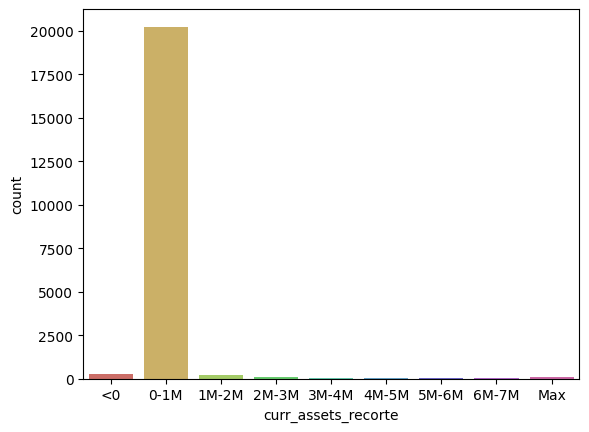

In [150]:
# fazendo gráfico:

sns.countplot(x='curr_assets_recorte', data=df, palette='hls')

plt.show()

#dropando a coluna:

df = df.drop(['curr_assets_recorte'], axis=1)

### 4.3.5. Passivos Circulantes

In [151]:
# verificando 10 recortes da variável curr_liab e a porcentagem de empresas fechadas em cada recorte:
print(df['curr_liab'].min())
print(df['curr_liab'].max())

# criando recortes para a variável:

df['curr_liab_recorte'] = pd.cut(df['curr_liab'], bins=[df['curr_liab'].min(), 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, df['curr_liab'].max() ], labels=['<0', '0-1M', '1M-2M', '2M-3M', '3M-4M', '4M-5M', '5M-6M', '6M-7M', 'Max'])

# tabela com porcentagem de empresas fechadas por curr_liab_recorte:

pd.crosstab(df['curr_liab_recorte'], df['will_close']).apply(lambda r: r/r.sum(), axis=1)



-8759.2587890625
326405120.0


will_close,0,1
curr_liab_recorte,,
<0,0.979544,0.020456
0-1M,0.974179,0.025821
1M-2M,0.958549,0.041451
2M-3M,0.973684,0.026316
3M-4M,0.951220,0.048780
4M-5M,1.000000,0.000000
5M-6M,1.000000,0.000000
6M-7M,1.000000,0.000000
Max,0.987013,0.012987


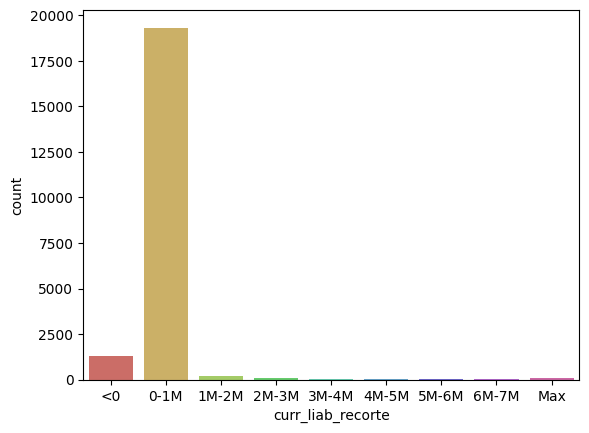

In [152]:
# fazendo gráfico:

sns.countplot(x='curr_liab_recorte', data=df, palette='hls')
plt.show()


#dropando a coluna curr_liab_recorte:
df = df.drop(['curr_liab_recorte'], axis=1)

### 4.3.5. Lucros ou Perdas

In [153]:
# profit_loss_year
# verificando 10 recortes da variável profit_loss_year e a porcentagem de empresas fechadas em cada recorte:
print(df['profit_loss_year'].min())
print(df['profit_loss_year'].max())

# criando recortes para a variável:

df['profit_loss_year_recorte'] = pd.cut(df['profit_loss_year'], bins=[df['profit_loss_year'].min(), 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, df['profit_loss_year'].max() ], labels=['<0', '0-1M', '1M-2M', '2M-3M', '3M-4M', '4M-5M', '5M-6M', '6M-7M', 'Max'])

# tabela com porcentagem de empresas fechadas por profit_loss_year_recorte:

pd.crosstab(df['profit_loss_year_recorte'], df['will_close']).apply(lambda r: r/r.sum(), axis=1)



-13973230.0
17001730.0


will_close,0,1
profit_loss_year_recorte,,
<0,0.977231,0.022769
0-1M,0.970641,0.029359
1M-2M,0.968750,0.031250
2M-3M,1.000000,0.000000
3M-4M,1.000000,0.000000
4M-5M,1.000000,0.000000
5M-6M,1.000000,0.000000
6M-7M,1.000000,0.000000
Max,1.000000,0.000000


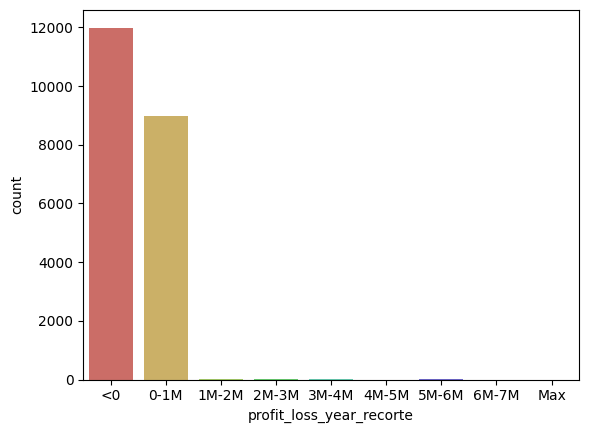

In [154]:
# fazendo gráfico:

sns.countplot(x='profit_loss_year_recorte', data=df, palette='hls')

plt.show()

#dropando a coluna profit_loss_year_recorte:

df = df.drop(['profit_loss_year_recorte'], axis=1)

### 4.3.7. Patrimônio líquido

In [155]:
# verificando 10 recortes da variável share_eq e a porcentagem de empresas fechadas em cada recorte:

print(df['share_eq'].min())

print(df['share_eq'].max())

# criando recortes para a variável:

df['share_eq_recorte'] = pd.cut(df['share_eq'], bins=[df['share_eq'].min(), 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, df['share_eq'].max() ], labels=['<0', '0-1M', '1M-2M', '2M-3M', '3M-4M', '4M-5M', '5M-6M', '6M-7M', 'Max'])

# tabela com porcentagem de empresas fechadas por share_eq_recorte:

pd.crosstab(df['share_eq_recorte'], df['will_close']).apply(lambda r: r/r.sum(), axis=1)



-39509640.0
692925952.0


will_close,0,1
share_eq_recorte,,
<0,0.977396,0.022604
0-1M,0.972310,0.027690
1M-2M,0.977169,0.022831
2M-3M,1.000000,0.000000
3M-4M,0.935484,0.064516
4M-5M,0.953488,0.046512
5M-6M,1.000000,0.000000
6M-7M,1.000000,0.000000
Max,0.989899,0.010101


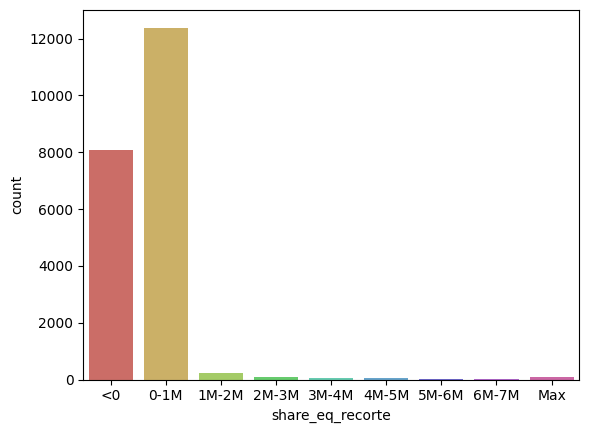

In [156]:
# fazendo gráfico:

sns.countplot(x='share_eq_recorte', data=df, palette='hls')

plt.show()

#dropando a coluna share_eq_recorte:

df = df.drop(['share_eq_recorte'], axis=1)

### 4.3.8. Capital Subscrito

In [157]:
# verificando 10 recortes da variável subscribed_cap e a porcentagem de empresas fechadas em cada recorte:

print(df['subscribed_cap'].min())

print(df['subscribed_cap'].max())

# criando recortes para a variável:

df['subscribed_cap_recorte'] = pd.cut(df['subscribed_cap'], bins=[df['subscribed_cap'].min(), 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, df['subscribed_cap'].max() ], labels=['<0', '0-1M', '1M-2M', '2M-3M', '3M-4M', '4M-5M', '5M-6M', '6M-7M', 'Max'])

# tabela com porcentagem de empresas fechadas por subscribed_cap_recorte:

pd.crosstab(df['subscribed_cap_recorte'], df['will_close']).apply(lambda r: r/r.sum(), axis=1)




-303.7037048339844
159444448.0


will_close,0,1
subscribed_cap_recorte,,
<0,1.000000,0.000000
0-1M,0.974445,0.025555
1M-2M,0.931818,0.068182
2M-3M,1.000000,0.000000
3M-4M,1.000000,0.000000
4M-5M,1.000000,0.000000
5M-6M,1.000000,0.000000
6M-7M,1.000000,0.000000
Max,0.972222,0.027778


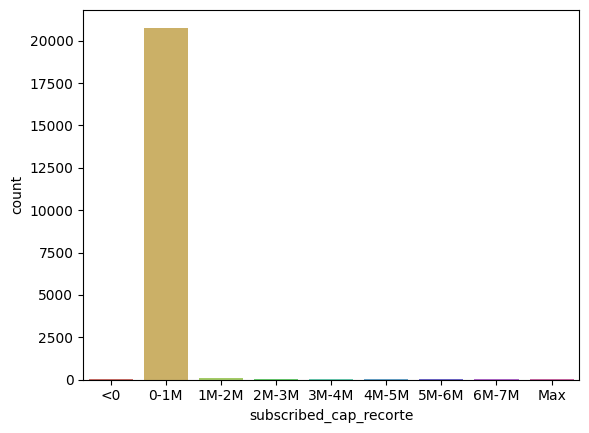

In [158]:
# fazendo gráfico:

sns.countplot(x='subscribed_cap_recorte', data=df, palette='hls')

plt.show()

# dropando a coluna subscribed_cap_recorte:

df = df.drop(['subscribed_cap_recorte'], axis=1)

### 4.3.9. Resultado Antes de Impostos

In [159]:
# verificando 10 recortes da variável inc_bef_tax e a porcentagem de empresas fechadas em cada recorte:

print(df['inc_bef_tax'].min())

print(df['inc_bef_tax'].max())

# criando recortes para a variável:

df['inc_bef_tax_recorte'] = pd.cut(df['inc_bef_tax'], bins=[df['inc_bef_tax'].min(), 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, df['inc_bef_tax'].max() ], labels=['<0', '0-1M', '1M-2M', '2M-3M', '3M-4M', '4M-5M', '5M-6M', '6M-7M', 'Max'])

# tabela com porcentagem de empresas fechadas por inc_bef_tax_recorte:

pd.crosstab(df['inc_bef_tax_recorte'], df['will_close']).apply(lambda r: r/r.sum(), axis=1)



-13973230.0
77992592.0


will_close,0,1
inc_bef_tax_recorte,,
<0,0.977259,0.022741
0-1M,0.970905,0.029095
1M-2M,0.980769,0.019231
2M-3M,1.000000,0.000000
3M-4M,1.000000,0.000000
4M-5M,1.000000,0.000000
5M-6M,1.000000,0.000000
6M-7M,1.000000,0.000000
Max,1.000000,0.000000


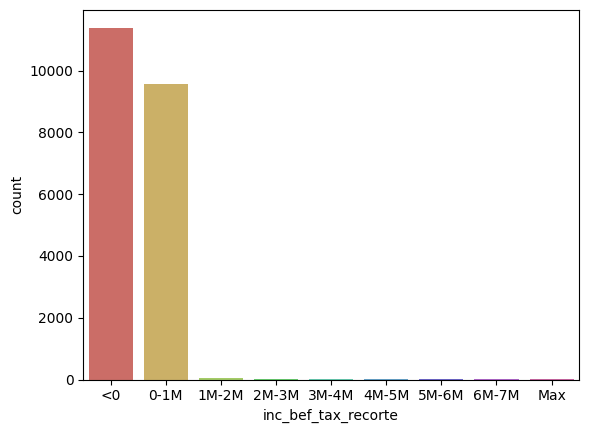

In [160]:
# fazendo gráfico:

sns.countplot(x='inc_bef_tax_recorte', data=df, palette='hls')

plt.show()

# dropando a coluna inc_bef_tax_recorte:

df = df.drop(['inc_bef_tax_recorte'], axis=1)

### 4.3.10. Ativos Intangíveis

In [161]:
# verificando 10 recortes da variável intang_assets e a porcentagem de empresas fechadas em cada recorte:

print(df['intang_assets'].min())

print(df['intang_assets'].max())

# criando recortes para a variável:

df['intang_assets_recorte'] = pd.cut(df['intang_assets'], bins=[df['intang_assets'].min(), 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, df['intang_assets'].max() ], labels=['<0', '0-1M', '1M-2M', '2M-3M', '3M-4M', '4M-5M', '5M-6M', '6M-7M', 'Max'])

# tabela com porcentagem de empresas fechadas por intang_assets_recorte:

pd.crosstab(df['intang_assets_recorte'], df['will_close']).apply(lambda r: r/r.sum(), axis=1)

-29.62962913513184
159444448.0


will_close,0,1
intang_assets_recorte,,
<0,0.975143,0.024857
0-1M,0.969395,0.030605
1M-2M,1.000000,0.000000
2M-3M,1.000000,0.000000
3M-4M,1.000000,0.000000
4M-5M,1.000000,0.000000
5M-6M,1.000000,0.000000
Max,1.000000,0.000000


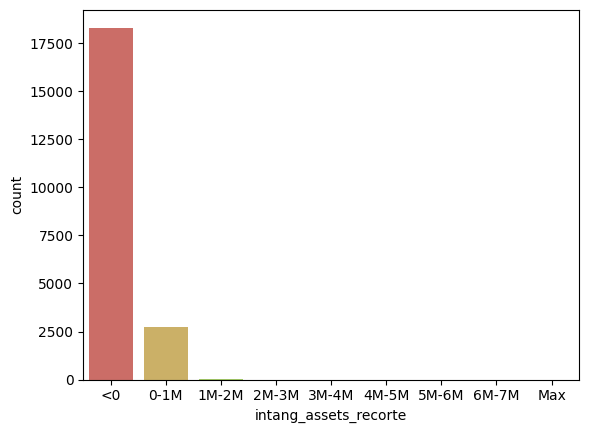

In [162]:
# fazendo gráfico:

sns.countplot(x='intang_assets_recorte', data=df, palette='hls')

plt.show()

# dropando a coluna intang_assets_recorte:

df = df.drop(['intang_assets_recorte'], axis=1)

# PASSO 05 - FILTRAGEM DE VARIÁVEIS

## 5.1. Selecao das Colunas


- variáveis com datas ou anos 'begin', 'end', 'year', 'founded_year', 'exit_year', 'exit_date'. Os modelos a serem aplicados não suportam esse tipo de variável.
- dados sobre o balanço 'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear'. Número relevante de missing values.
- Informações sobre Boarding "ceo_count", "foreign", "female", "birth_year", "inoffice_days", "gender", "origin". Possuem número relevantes de missing values além de poderem causar viés inesperado no modelo, uma vez que não há evidências que essas variáveis influenciam a gestão de uma empresa
- Informações sobre o setor de atuação da empresa: 'nace_main', 'ind2', 'ind'. Como serão utilizados dados somente de 2012 para a construção do modelo, pode-se criar a falsa correlação que uma empresa pode falir por atuar num determinado setor que, por questões exógenas, pode apresentar melhores condições para uma empresa por questões de conjuntura econômica.


In [163]:
df = df.drop(['begin', 'end', 'year', 'founded_year','founded_date', 'exit_year', 'exit_date', # variáveis com datas
              
              "ceo_count", "foreign", "female", "birth_year", "inoffice_days", "gender", "origin", # variáveis de CEO / Boaridng
              
              'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear', # variáveis sobre o balanço com muitos missing values
              
              'nace_main', 'ind', 'ind2', # variáveis sobre o setor de atuação da empresa que pode enviesar o modelo
              
              'index', # não é útil para o modelo
              'revenue', # não utilizaremos no modelo
              'log_sales' # não utilizaremos no modelo 
                                      
              ], axis=1) 

df.isna().sum()

comp_id              0
amort                0
curr_assets          0
curr_liab            0
extra_exp            0
extra_inc            0
extra_profit_loss    0
fixed_assets         0
inc_bef_tax          0
intang_assets        0
inventories          0
liq_assets           0
material_exp         0
personnel_exp        0
profit_loss_year     0
sales_x              0
share_eq             0
subscribed_cap       0
tang_assets          0
urban_m              0
region_m             0
labor_avg            0
will_close           0
revenue              0
curr_idx_liq         0
comp_age             0
comp_size            0
dtype: int64

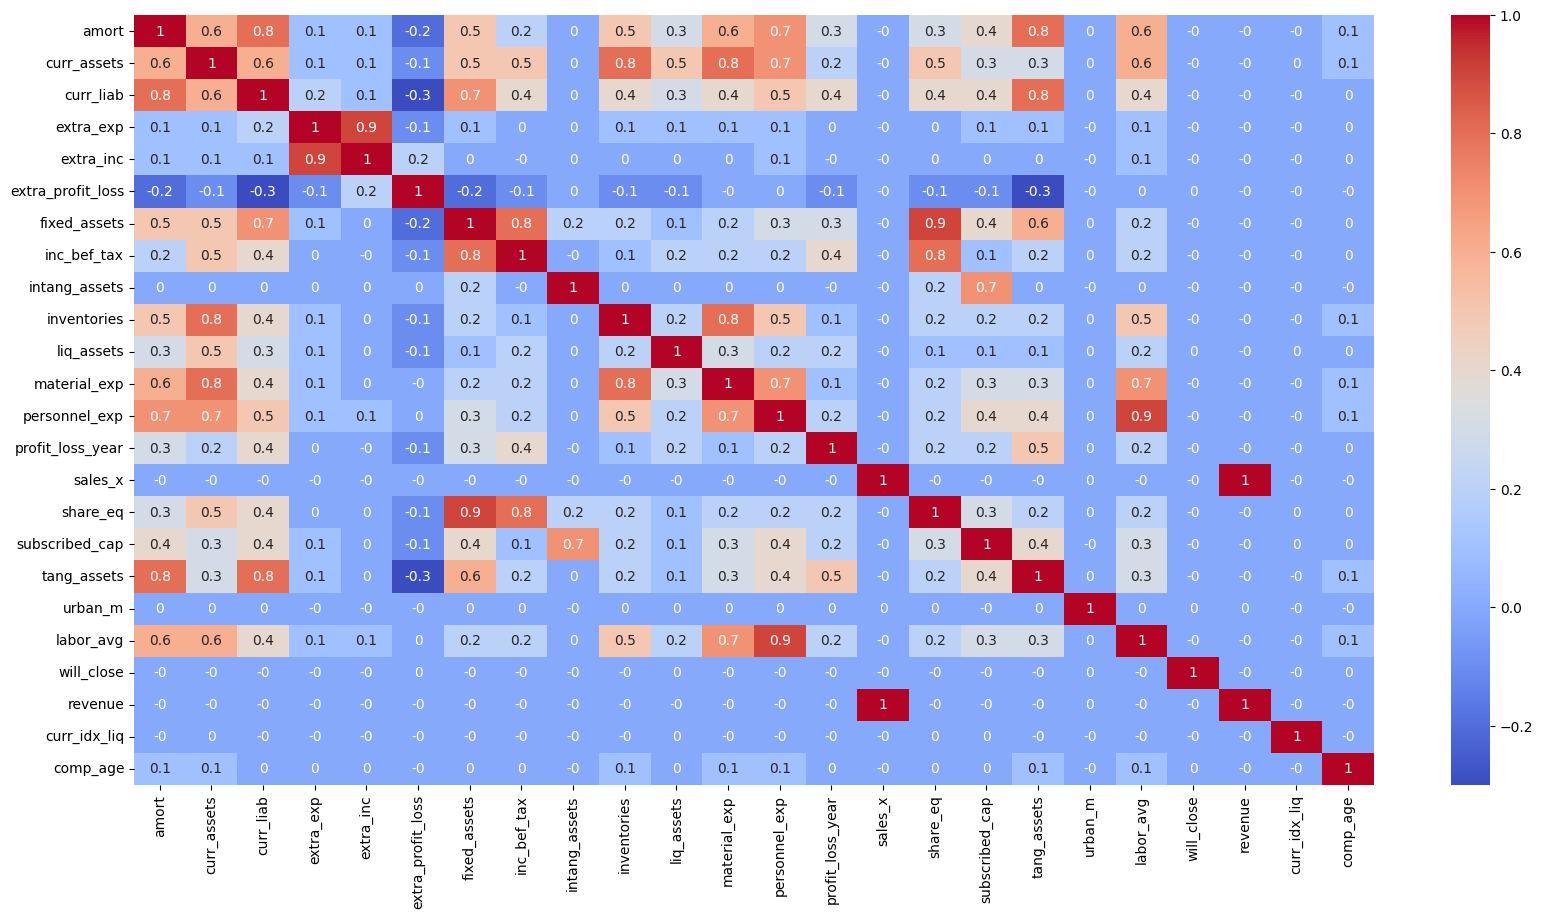

In [164]:

# atualizando variável var_num:
var_num = df.select_dtypes( include=['int64', 'float64'] )

# fazendo heatmap com o restante das variáveis:
plt.figure(figsize=(20,10))
sns.heatmap(round(var_num.corr(),1), annot=True, cmap='coolwarm')
plt.show()

# 6. Exportando dados

In [165]:
# exportando df para csv:
df.to_csv('df.csv', index=False)